# Installations and Imports

In [2]:
! sudo apt-get update
! pip install 'imageio==2.4.0'
! sudo apt-get install -y xvfb ffmpeg
! pip3 install gymnasium[classic_control]


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package list

In [3]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
import gymnasium as gym
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# Utility functions for rendering evironment

In [4]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [5]:
def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                video.append_data(env.render())
                if terminated:
                    break
    return embed_mp4(filename)

# Replay Memory and Q-Network

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [119]:
# Complete the Q-Network below. 
# The Q-Network takes a state as input and the output is a vector so that each element is the q-value for an action.

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
         # ==================================== Your Code (Begin) ====================================
        super(DQN, self).__init__()
        self.model = nn.Sequential(
          nn.Linear(n_observations, 128), 
          nn.ReLU(),
          nn.Linear(128, 128), 
          nn.ReLU(),
          nn.Linear(128, n_actions)
        )
        # ==================================== Your Code (End) ====================================


    def forward(self, x):
        # ==================================== Your Code (Begin) ====================================
        return self.model(x)
        # ==================================== Your Code (End) ====================================

# Policies

Now we define 2 policies. We use greedy policy for evaluation and e-greedy during training.

In [8]:
# This function takes in a state and returns the best action according to your q-network.
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network. 

# state shape: (1, state_size) -> output shape: (1, 1)  
def greedy_policy(qnet, state):
    # ==================================== Your Code (Begin) ====================================
    with torch.no_grad():
        return qnet(state).max(1)[1].view(1, 1)

    # ==================================== Your Code (End) ====================================

In [9]:
# state shape: (1, state_size) -> output shape: (1, 1)
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network.
import random
def e_greedy_policy(qnet, state, current_timestep):
    # ==================================== Your Code (Begin) ====================================

    # With probability "eps_threshold" choose a random action 
    # and with probability 1-"eps_threshold" choose the best action according to your Q-Network.
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * current_timestep / EPS_DECAY)
    if random.uniform(0, 1) < eps_threshold:
        return torch.tensor([[env.action_space.sample()]]).view(1,1)
    else:
        return greedy_policy(qnet, state)

    
    # ==================================== Your Code (End) ====================================

In [10]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
state, info = env.reset()
n_observations = len(state)
n_observations

4

# Initial setup

In [216]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 700
TAU = 0.005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)
optimizer = optim.AdamW(q_network.parameters(), lr=LR)
memory = ReplayMemory(10000)
criterion = nn.SmoothL1Loss()

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "random_agent")

# Training

In [12]:
DEVICE

device(type='cuda')

100%|██████████| 600/600 [02:25<00:00,  4.13it/s]

Complete


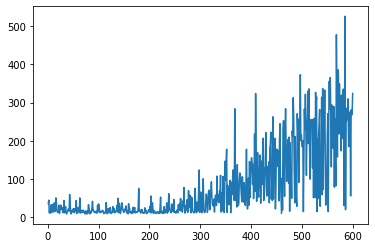

In [198]:
from os import stat_result
from tqdm import tqdm
import numpy as np

num_episodes = 600
episode_returns = []
episode_durations = []
all_losses = []
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)

optimizer = optim.AdamW(q_network.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10_000)
criterion = nn.SmoothL1Loss()


for i_episode in tqdm(range(num_episodes)):

    # ==================================== Your Code (Begin) ====================================
    # 1. Start a new episode
    # 2. Run the environment for 1 step using e-greedy policy
    # 3. Add the (state, action, next_state, reward) to replay memory
    # 4. Optimize your q_network for 1 iteration
    #       4.1 Sample one batch from replay memory
    #       4.2 Compute predicted state-action values using q_network
    #       4.3 Compute expected state-action values using target_network (Don't forget "no_grad" because we don't want gradient through target_network)
    #       4.4 Compute loss function and optimize q_network for 1 step
    # 5. Soft update the weights of target_network
    #       θ′ ← τ θ + (1 −τ )θ′
    #       θ   is q_network weights
    #       θ′  is target_network weights            
    # 6. Keep track of the total reward for each episode to plot later
    # ==================================== Your Code (End) ==================================== 
    current_timestep = 0
    done = False 
    total_reward = 0 
    total_loss = 0
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while not done:
        action = e_greedy_policy(q_network,state, i_episode)
        action = torch.tensor([[action]], device=device)
        next_state, reward, done, _, _ = env.step(action.item())
       
        total_reward += reward
        next_state = torch.tensor(next_state,  dtype=torch.float32, device=DEVICE).unsqueeze(0)
        reward = torch.tensor([reward], device=DEVICE)
        if done:
            episode_durations.append(current_timestep + 1)
            episode_returns.append(total_reward)
            all_losses.append(total_loss/BATCH_SIZE)
        
        memory.push((state, action.to(DEVICE), next_state, reward, int(done)))
        current_timestep += 1
        state = next_state
        # # optimization
        if len(memory) < BATCH_SIZE:
            continue
        all_states, all_actions, all_next_states, all_rewards, all_done = zip(*memory.sample(BATCH_SIZE))
        all_states = torch.cat(all_states)
        all_next_states = torch.cat(all_next_states)
        all_rewards = torch.cat(all_rewards)
        all_actions = torch.cat(all_actions)
        all_done  = torch.tensor(all_done).to(DEVICE)
        q_net_out = q_network(all_states).gather(1, all_actions)

        with torch.no_grad():
            target_net_out = target_network(all_next_states).max(1)[0]
            target_net_out =  (1-all_done)*target_net_out
        target_net_out = (target_net_out * GAMMA) + all_rewards
        loss = criterion(q_net_out, target_net_out.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        # end optimization 
        temp_weights_dict = target_network.state_dict()
        if i_episode % 10 == 0 :
            for k, v in q_network.state_dict().items():
                temp_weights_dict[k] = TAU * v + (1-TAU)*temp_weights_dict[k]
            target_network.load_state_dict(temp_weights_dict)
     

print('Complete')
plt.plot(range(1, num_episodes+1), episode_durations)

In [196]:
# Render trained model

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "trained_agent")

## NOTE :
I dont know why th evideo is not shown when i download the notebook from colab. I have put the video in the zip folder of the solutions